# Day 08. Exercise 02
# Multiclass classification. One-hot encoding. Random forest

## 0. Imports

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

## 1. Preprocessing

1. Read the file [`checker-submits.csv`](https://drive.google.com/file/d/14voc4fNJZiLEFaZyd8nEG-lQt5JjatYw/view?usp=sharing).
2. Create a dataframe `df` with the columns: `uid`, `labname`, `numTrials`, `hour`, `dayofweek` where `hour` is extracted from the `timestamp` as well as the `dayofweek` (`0` is Monday, `6` is Sunday). We will try to predict the day of the week having data about which user made a commit for which lab at which hour and which try it was.
3. Using `OneHotEncoder()` transform your categorical features, delete from the dataframe the initial columns.
4. Use `StandardScaler()` and scale your continuous features.
5. Save the dataframe as `dayofweek.csv`.
6. Before trying out different algorithms, find out the accuracy of the naive algorithms – the one that predicts everything as the most popular class.

In [3]:
df = pd.read_csv('../data/checker_submits.csv', parse_dates=['timestamp'])
df.head()

,uid,labname,numTrials,timestamp
0,user_4,project1,1,2020-04-17 05:19:02.744528
1,user_4,project1,2,2020-04-17 05:22:45.549397
2,user_4,project1,3,2020-04-17 05:34:24.422370
3,user_4,project1,4,2020-04-17 05:43:27.773992
4,user_4,project1,5,2020-04-17 05:46:32.275104


In [4]:
df['hour'] = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.dayofweek
df.drop('timestamp', axis=1, inplace=True)

In [5]:
encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(df[['uid', 'labname']])
encoded_columns = encoder.get_feature_names_out()
df_encoded = pd.DataFrame(encoded_features, columns=encoded_columns)
df = pd.concat([df[['numTrials', 'hour', 'dayofweek']], df_encoded], axis=1)

In [6]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[['numTrials', 'hour']])
df[['numTrials', 'hour']] = scaled_features

In [7]:
df.shape

(1686, 44)

In [8]:
df.to_csv('../data/dayofweek.csv', index=False)

In [9]:
y_median = df['dayofweek'].apply(lambda x: df['dayofweek'].median())

In [10]:
accuracy_score(df['dayofweek'], y_median)

0.23487544483985764

## 2. Algorithms

### a. Logreg

1. Train logistic regression, for the baseline model use `random_state=21`, `fit_intercept=False`. 
2. Calculate the accuracy.
3. Write a function that draws the plot (`barh`) taking coefficients of any trained models, names of the features and the number of `top-n` most important features to display.
4. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model.
5. Remember that it is a multiclass classification and `coef_` returns a matrix, to calculate importance for a feature you need to sum all the individual feature importances for all the target values.

In [11]:
X_train = df.drop('dayofweek', axis=1)
y_train = df['dayofweek']

In [12]:
lr = LogisticRegression(random_state=21, fit_intercept=False)
lr.fit(X_train, y_train)
y_lr = lr.predict(X_train)

accuracy_score(y_train, y_lr)

0.6405693950177936

In [43]:
def draw_feature_importance(coefficients, feature_names, top_n):
    importance = np.abs(coefficients).sum(axis=0)
    indices = np.argsort(importance)[-top_n:]
    plt.figure(figsize=(8, 6))
    plt.barh(range(top_n), importance[indices], align='center')
    plt.yticks(range(top_n), [feature_names[i] for i in indices])
    plt.xlabel('Importance')
    plt.title('Top {} Most Important Features'.format(top_n))
    plt.show()

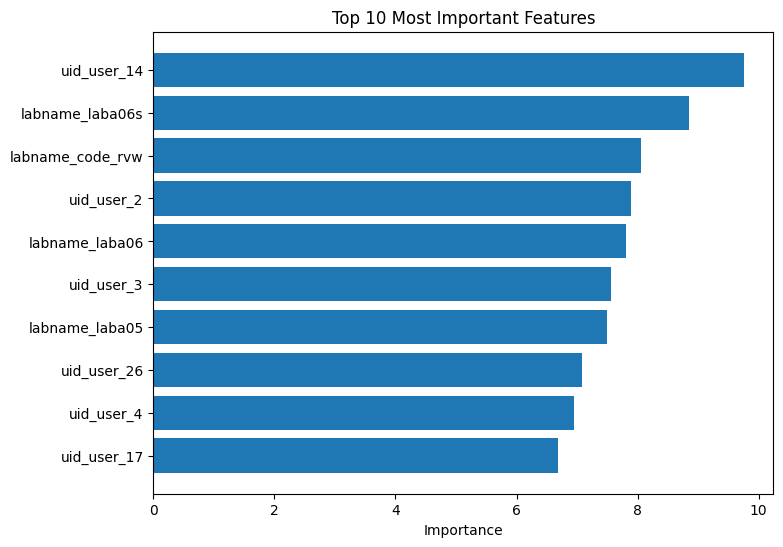

In [44]:
draw_feature_importance(lr.coef_, X_train.columns, 10)

### b. SVC

1. Train a `SVC` model, for the baseline model use parameters `kernel='linear'`, `probability=True`, `random_state=21`. 
2. Try different kernels, calculate the accuracies.
3. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model for the linear kernel *

*By default SVC uses “one vs one” strategy of the classification, thus in `coef_` it returns a matrix. To calculate importance for a feature you need to use [OneVsRestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) over the SVC and sum all the individual feature importances for all the target values.

Baseline Accuracy: 0.702846975088968


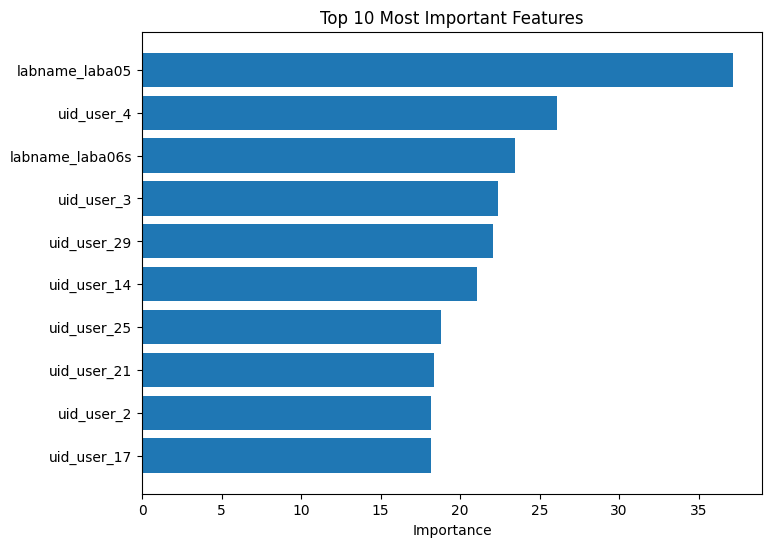

In [45]:
svc = SVC(kernel='linear', probability=True, random_state=21)
svc.fit(X_train, y_train)

accuracy_baseline = svc.score(X_train, y_train)
print("Baseline Accuracy:", accuracy_baseline)

draw_feature_importance(svc.coef_, X_train.columns, 10)

### c. Decision tree

1. Train a `DecisionTreeClassifier` using for the baseline model `max_depth=4`, `random_state=21`. 
2. Try different values of `max_depth`, calculate the accuracies.
3. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model using the written function.

In [52]:
dtree = DecisionTreeClassifier(max_depth=4, random_state=21)
dtree.fit(X_train, y_train)

y_pred = dtree.predict(X_train)

accuracy = accuracy_score(y_train, y_pred)
print("Точность базовой модели:", accuracy)

Точность базовой модели: 0.5516014234875445


In [22]:
param_grid = {'max_depth': range(1, 10)}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=21), param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)

Лучшие параметры: {'max_depth': 9}


In [32]:
best_tree = DecisionTreeClassifier(max_depth=9, random_state=21).fit(X_train, y_train)
accuracy = accuracy_score(y_train, best_tree.predict(X_train))
print("Точность модели:", accuracy)

Точность модели: 0.7846975088967971


In [38]:
def plot_feature_importance(coefficients, feature_names, top_n=10):
    coef_abs = np.abs(coefficients)    
    sorted_idx = np.argsort(coef_abs)    
    top_n_idx = sorted_idx[-top_n:]    
    plt.barh(feature_names[top_n_idx], coef_abs[top_n_idx])
    plt.xlabel('Важность признака')
    plt.ylabel('Признак')
    plt.title('Топ-10 важных признаков')
    plt.show()

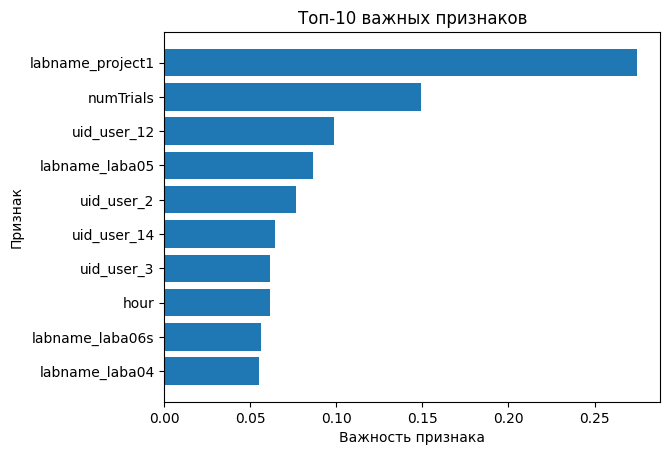

In [53]:
plot_feature_importance(dtree.feature_importances_, X_train.columns, 10)

### d. Random forest

In real life forest is a set of trees. The same thing is with machine learning. Random forest is a set of individual decision trees (check the documentation for more details).

1. Train a `RandomForestClassifier` using for the baseline model parameters `n_estimators=100`, `max_depth = 25`, `random_state=21`. 
2. Try different values of `max_depth` and `n_estimators`, calculate the accuracies.
3. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model using the written function.

In [48]:
rf = RandomForestClassifier(n_estimators=100,
                             max_depth=25,
                             random_state=21)
rf.fit(X_train, y_train)


accuracy_score(y_train, rf.predict(X_train))

1.0

In [49]:
accuracy_score(y_train, RandomForestClassifier(n_estimators=10,
                             max_depth=20,
                             random_state=21).fit(X_train, y_train).predict(X_train))

0.9839857651245552

In [50]:
accuracy_score(y_train, RandomForestClassifier(n_estimators=50,
                             max_depth=10,
                             random_state=21).fit(X_train, y_train).predict(X_train))

0.8701067615658363

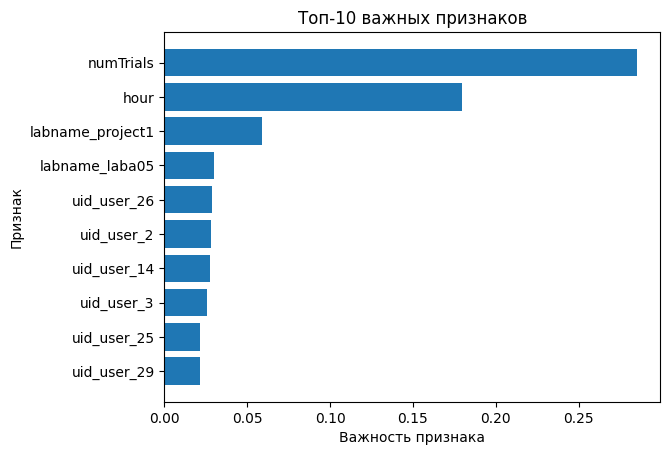

In [51]:
plot_feature_importance(rf.feature_importances_, X_train.columns, 10)